# Identifying Fraud at Enron Using Emails and Financial Data


## Udacity Course - Intro to Machine Learning Final Project


### Project Introduction

<p>
<div style="background-color:#d9d9d9">In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives. 
<p><p>
For this project, predictive models were built using scikit learn, numpy, and pandas modules in Python. The target of the predictions were persons-of-interest (POI’s) who were ‘individuals who were indicted, reached a settlement, or plea deal with the government, or testified in exchange for prosecution immunity.’ Financial compensation data and aggregate email statistics from the Enron Corpus were used as features for prediction.
<p>
The goal of this project wass the build a prediction model to identify persons-of-interest (POI’s.) </div>

### Understanding the Dataset and Question

#### Data Exploration (related mini-project: Lesson 5)

<p>
<div style="background-color:#d9d9d9">Student response addresses the most important characteristics of the dataset and uses these characteristics to inform their analysis. 
<p><p>
Important characteristics include:
    Total number of data points
    Allocation across classes (POI/non-POI)
    Number of features used
    Are there features with many missing values? etc.</div>

In [63]:
# import libraries
import sys
import pickle
import numpy as np
import pandas as pd
import sklearn
#from ggplot import *
import matplotlib as plt
%matplotlib inline

sys.path.append("../tools/")
import tester

from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, dump_classifier_and_data


In [2]:
# features_list is a list of strings, each of which is a feature name.
# The first feature must be "poi".
features_list = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 
                 'loan_advances', 'bonus', 'restricted_stock_deferred', 
                 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 
                 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees'] 

### Load the dictionary containing the dataset
with open("final_project_dataset_modified.pkl", "r") as data_file:
    enron_dict = pickle.load(data_file)
    
enron_dict['METTS MARK'].keys()

f = open('poi_names.txt', 'r')


The features in the data fall into three major types, namely financial features, email features and POI labels.

financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

POI label: [‘poi’] (boolean, represented as integer)

I'm going to try to use all features, filter them and choose the best.

In [3]:
# Change data dictionary to pandas DataFrame
df = pd.DataFrame.from_records(list(enron_dict.values()))
persons = pd.Series(list(enron_dict.keys()))

print persons.head()
print df.head()

0          METTS MARK
1       BAXTER JOHN C
2      ELLIOTT STEVEN
3    CORDES WILLIAM R
4      HANNON KEVIN P
dtype: object
     bonus deferral_payments deferred_income director_fees  \
0   600000               NaN             NaN           NaN   
1  1200000           1295738        -1386055           NaN   
2   350000               NaN         -400729           NaN   
3      NaN               NaN             NaN           NaN   
4  1500000               NaN        -3117011           NaN   

              email_address exercised_stock_options expenses from_messages  \
0      mark.metts@enron.com                     NaN    94299            29   
1                       NaN                 6680544    11200           NaN   
2  steven.elliott@enron.com                 4890344    78552           NaN   
3     bill.cordes@enron.com                  651850      NaN            12   
4    kevin.hannon@enron.com                 5538001    34039            32   

  from_poi_to_this_person from_thi

In [4]:
# dataframe dimension
df.shape

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 21 columns):
bonus                        143 non-null object
deferral_payments            143 non-null object
deferred_income              143 non-null object
director_fees                143 non-null object
email_address                143 non-null object
exercised_stock_options      143 non-null object
expenses                     143 non-null object
from_messages                143 non-null object
from_poi_to_this_person      143 non-null object
from_this_person_to_poi      143 non-null object
loan_advances                143 non-null object
long_term_incentive          143 non-null object
other                        143 non-null object
poi                          143 non-null bool
restricted_stock             143 non-null object
restricted_stock_deferred    143 non-null object
salary                       143 non-null object
shared_receipt_with_poi      143 non-null object
to_messages    

In [5]:
print enron_dict.keys()

['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHAPIRO RICHARD S', 'SHERRIFF JOHN R', 'SHELBY 

In [6]:
print 'Columns:', list(df.columns.values)
print 'Shape:', df.shape
print 'Number of POI in the dataset:', (df['poi'] == 1).sum()
print 'Number of non-POI in the dataset:', (df['poi'] == 0).sum()

Columns: ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'email_address', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 'poi', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']
Shape: (143, 21)
Number of POI in the dataset: 16
Number of non-POI in the dataset: 127


In [7]:
# convert to numpy.nan
df.replace(to_replace='NaN', value=np.nan, inplace=True)

# count number of nan for columns
print df.isnull().sum()


bonus                         64
deferral_payments            106
deferred_income               96
director_fees                127
email_address                 34
exercised_stock_options       44
expenses                      51
from_messages                 59
from_poi_to_this_person       59
from_this_person_to_poi       59
loan_advances                141
long_term_incentive           80
other                         53
poi                            0
restricted_stock              36
restricted_stock_deferred    126
salary                        51
shared_receipt_with_poi       59
to_messages                   59
total_payments                21
total_stock_value             20
dtype: int64


There were 143 total records and 16 POIs in the original dataset.

All features have null data.

#### Outlier Investigation (related mini-project: Lesson 7)

<p>
<div style="background-color:#d9d9d9">Student response identifies outlier(s) in the financial data, and explains how they are removed or otherwise handled.</div>

In [8]:
# remove column from df if null counter > 65
for column, series in df.iteritems():
    if series.isnull().sum() > 65:
        df.drop(column, axis=1, inplace=True)

# remove email address column
if 'email_address' in list(df.columns.values):
    df.drop('email_address', axis=1, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 14 columns):
bonus                      79 non-null float64
exercised_stock_options    99 non-null float64
expenses                   92 non-null float64
from_messages              84 non-null float64
from_poi_to_this_person    84 non-null float64
from_this_person_to_poi    84 non-null float64
other                      90 non-null float64
poi                        143 non-null bool
restricted_stock           107 non-null float64
salary                     92 non-null float64
shared_receipt_with_poi    84 non-null float64
to_messages                84 non-null float64
total_payments             122 non-null float64
total_stock_value          123 non-null float64
dtypes: bool(1), float64(13)
memory usage: 14.7 KB


In [10]:
# Impute the missing values
#from sklearn.preprocessing import Imputer
#imp = Imputer(missing_values='NaN', strategy='median', axis=0)
#imp.fit(df)
#df_imp = pd.DataFrame(imp.transform(df.copy(deep=True)))

df_imp = df.replace(to_replace=np.nan, value=0)
df_imp = df.fillna(0).copy(deep=True)
df_imp.columns = list(df.columns.values)

print df_imp.isnull().sum()
print df_imp.head()

df_imp.describe()


bonus                      0
exercised_stock_options    0
expenses                   0
from_messages              0
from_poi_to_this_person    0
from_this_person_to_poi    0
other                      0
poi                        0
restricted_stock           0
salary                     0
shared_receipt_with_poi    0
to_messages                0
total_payments             0
total_stock_value          0
dtype: int64
       bonus  exercised_stock_options  expenses  from_messages  \
0   600000.0                      0.0   94299.0           29.0   
1  1200000.0                6680544.0   11200.0            0.0   
2   350000.0                4890344.0   78552.0            0.0   
3        0.0                 651850.0       0.0           12.0   
4  1500000.0                5538001.0   34039.0           32.0   

   from_poi_to_this_person  from_this_person_to_poi      other    poi  \
0                     38.0                      1.0     1740.0  False   
1                      0.0            

,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,1.430000e+02,1.430000e+02,143.000000,143.000000,143.000000,143.000000,1.430000e+02,1.430000e+02,1.430000e+02,143.000000,143.000000,1.430000e+02,1.430000e+02
mean,5.926127e+05,1.715504e+06,34719.447552,365.118881,37.552448,24.475524,2.267385e+05,7.235235e+05,1.714731e+05,676.384615,1191.972028,1.489942e+06,2.404233e+06
std,1.036924e+06,3.694149e+06,45235.547286,1455.675655,74.148184,80.080666,7.552178e+05,1.571184e+06,1.660404e+05,1066.923179,2223.860300,2.386745e+06,4.422592e+06
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-2.604490e+06,0.000000e+00,0.000000,0.000000,0.000000e+00,-4.409300e+04
25%,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,8.929250e+04,2.148255e+05
50%,2.500000e+05,6.014380e+05,17355.000000,16.000000,1.000000,0.000000,8.910000e+02,3.466630e+05,2.061210e+05,91.000000,266.000000,9.114530e+05,9.543540e+05
75%,8.000000e+05,1.636136e+06,52688.500000,50.500000,39.500000,12.500000,1.492040e+05,6.801640e+05,2.670975e+05,869.000000,1504.000000,1.858492e+06,2.217787e+06
max,8.000000e+06,3.076606e+07,228763.000000,14368.000000,528.000000,609.000000,7.427621e+06,1.384707e+07,1.060932e+06,5521.000000,15149.000000,1.725253e+07,3.076606e+07


In [11]:
# drop row for 'THE TRAVEL AGENCY IN THE PARK'

park_index = enron_dict.keys().index('THE TRAVEL AGENCY IN THE PARK')
print park_index
df_imp_sub = df_imp.drop(df_imp.index[[park_index]])

99


In [12]:
enron_dict['LOCKHART EUGENE E']

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 'NaN',
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 'NaN',
 'total_stock_value': 'NaN'}

In [13]:
lockhart_index = enron_dict.keys().index('LOCKHART EUGENE E')
print lockhart_index
df_imp_sub = df_imp.drop(df_imp.index[[lockhart_index]])

89


'THE TRAVEL AGENCY IN THE PARK' was removed since it is not a person.
Eugene E. Lockhart was removed during data processing since this row had no entries for any feature.

### Optimize Feature Selection/Engineering

#### Create new features (related mini-project: Lesson 11)

<p>
<div style="background-color:#d9d9d9">At least one new feature is implemented. Justification for that feature is provided in the written response, and the effect of that feature on the final algorithm performance is tested. The student is not required to include their new feature in their final feature set.</div>

In [14]:
# Rename datafram name after cleaning up NaN and outlier
enron_df = df_imp_sub

#### Study Financial Features 

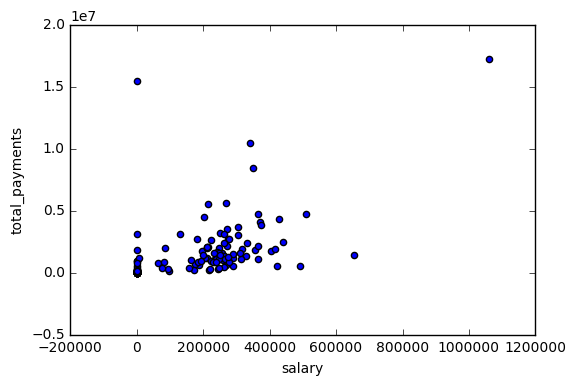

In [15]:
# Graph for features

import matplotlib.pyplot as plt

plt.scatter(enron_df['salary'], enron_df['total_payments'])
plt.xlabel("salary")
plt.ylabel("total_payments")
plt.show()

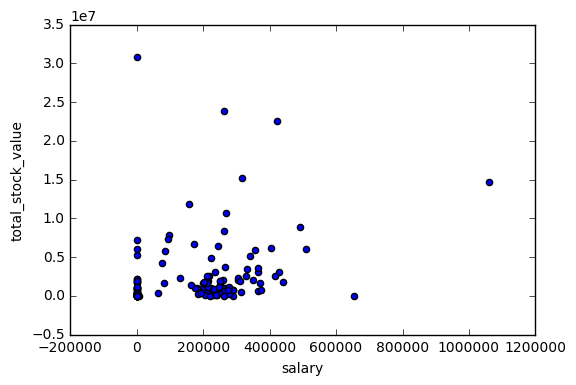

In [16]:
plt.scatter(enron_df['salary'], enron_df['total_stock_value'])
plt.xlabel("salary")
plt.ylabel("total_stock_value")
plt.show()

#### Create new features for financial features

In [17]:
enron_df[enron_df['total_stock_value'].isnull()]

,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,poi,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value


In [18]:
# Create new features 'salary_of_total_payment' and 'salary_of_total_stock_value'
enron_df['salary_of_total_payments'] = 0.0
enron_df['salary_of_total_stock_value'] = 0.0
enron_df.loc[enron_df['total_payments'] != 0.0,'salary_of_total_payments'] = enron_df['salary'] / enron_df['total_payments'] * 100
enron_df.loc[enron_df['total_stock_value'] != 0.0,'salary_of_total_stock_value'] = enron_df['salary'] / enron_df['total_stock_value'] * 100

In [19]:
enron_df.head()

,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,poi,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,salary_of_total_payments,salary_of_total_stock_value
0,600000.0,0.0,94299.0,29.0,38.0,1.0,1740.0,False,585062.0,365788.0,702.0,807.0,1061827.0,585062.0,34.448926,62.521237
1,1200000.0,6680544.0,11200.0,0.0,0.0,0.0,2660303.0,False,3942714.0,267102.0,0.0,0.0,5634343.0,10623258.0,4.740606,2.514313
2,350000.0,4890344.0,78552.0,0.0,0.0,0.0,12961.0,False,1788391.0,170941.0,0.0,0.0,211725.0,6678735.0,80.737277,2.559482
3,0.0,651850.0,0.0,12.0,10.0,0.0,0.0,False,386335.0,0.0,58.0,764.0,0.0,1038185.0,0.000000,0.000000
4,1500000.0,5538001.0,34039.0,32.0,32.0,21.0,11350.0,True,853064.0,243293.0,1035.0,1045.0,288682.0,6391065.0,84.277163,3.806768


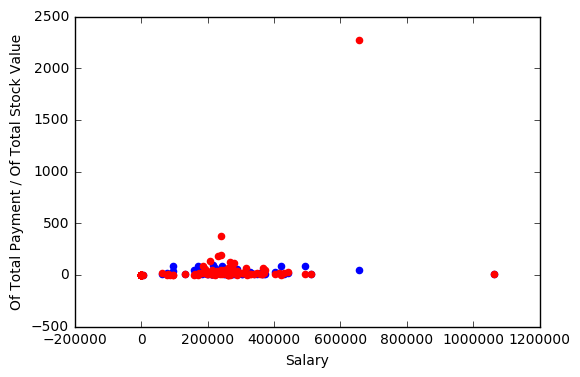

In [20]:
# Graph 'salary_of_total_payment' and 'salary_of_total_stock_value' to salary
plt.scatter(enron_df['salary'], enron_df['salary_of_total_payments'], color='blue')
plt.scatter(enron_df['salary'], enron_df['salary_of_total_stock_value'], color='red')
plt.xlabel('Salary')
plt.ylabel('Of Total Payment / Of Total Stock Value')
plt.show()


#### Create new features for email related features

In [21]:
# Mark as fraud for those with outrageous compensation
def outlierCleaner(predictions, ages, net_worths):
    """
        Clean away the 10% of points that have the largest
        residual errors (difference between the prediction
        and the actual net worth).

        Return a list of tuples named cleaned_data where
        each tuple is of the form (age, net_worth, error).
    """

    cleaned_data = []

    #print 'starting clean read data to tuple'
    #print 'length:', len(predictions)
    ### your code goes here
    for i in range(0, len(predictions)):
        age = ages[i][0]
        net_worth = net_worths[i][0]
        pred = predictions[i][0]
        err = net_worth - pred

        cleaned_data.append((age, net_worth, err))

    #print 'length of cleaned_data before sort:', len(cleaned_data)
    cleaned_data = sorted(cleaned_data, key=lambda x: x[2], reverse=True)[0:81]
    #print cleaned_data[-1]

    print 'length of cleaned_data:', len(cleaned_data)
    return cleaned_data


Create column 'poi_ratio' to store POI related message ratio in percentages. 

Also will be added next features:
the fraction of all emails to a person that were sent from a person of interest
the fraction of all emails that a person sent that were addressed to persons of interest

The hypothesis behind these features was that there might be stronger email connections between POIs than between 
POIs and non-POIs, and a scatterplot of these two features suggests that there might be some truth to that hypothesis.

Additionally I want to scale 'salary' to range [0,100].

In [22]:
enron_df['poi_ratio'] = 0.0
enron_df['fraction_to_poi'] = 0.0
enron_df['fraction_from_poi'] = 0.0

enron_df.loc[(enron_df['from_messages'] + enron_df['to_messages']) != 0.0, 'poi_ratio'] = (enron_df['from_poi_to_this_person'] + enron_df['from_this_person_to_poi']) / (enron_df['from_messages'] + enron_df['to_messages']) * 100
enron_df.loc[enron_df['from_messages'] != 0.0, 'fraction_to_poi'] = enron_df['from_this_person_to_poi'] / enron_df['from_messages'] * 100
enron_df.loc[enron_df['to_messages'] != 0.0, 'fraction_from_poi']= enron_df['from_poi_to_this_person'] / enron_df['to_messages'] * 100


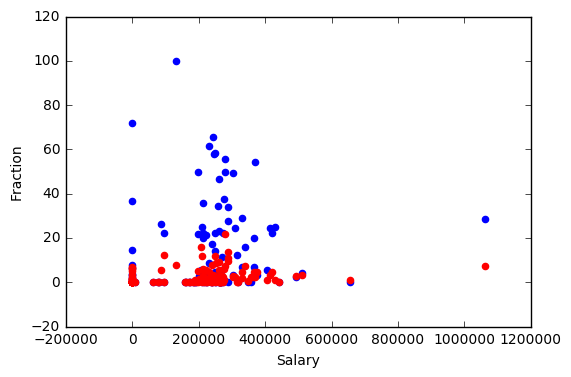

In [23]:
# Graph 'fraction_to_poi' and 'fraction_from_poi' to salary
plt.scatter(enron_df['salary'], enron_df['fraction_to_poi'], color='blue')
plt.scatter(enron_df['salary'], enron_df['fraction_from_poi'], color='red')
plt.xlabel('Salary')
plt.ylabel('Fraction')
plt.show()


In [24]:
# Create feature '' from email text

In [25]:
#from sklearn.feature_extraction.text import CountVectorizer
#vectorizer = CountVectorizer()
#email_list = []
#bag_of_words = vectorizer.fit(email_list)
#bag_of_words = vectorizer.transform(email_list)

#from nltk.corpus import stopwords
#sw = stopwords.words('english')

#from nltk.stem.snowball import SnowballStemmer
#stemmer = SnowballStemmer('english')
#stemmer.stem('responsive')

#### move 'poi' to the first column

In [26]:
# move 'poi' to the first column
cols = enron_df.columns.tolist()
#print cols
cols = cols[7:8] + cols[:7] + cols[8:]
#print cols
enron_df = enron_df[cols]
#print enron_df.columns.values


In [72]:
enron_df.columns.values

array(['poi', 'bonus', 'exercised_stock_options', 'expenses',
       'from_messages', 'from_poi_to_this_person',
       'from_this_person_to_poi', 'other', 'restricted_stock', 'salary',
       'shared_receipt_with_poi', 'to_messages', 'total_payments',
       'total_stock_value', 'salary_of_total_payments',
       'salary_of_total_stock_value', 'poi_ratio', 'fraction_to_poi',
       'fraction_from_poi'], dtype=object)

In [74]:
enron_df.head()

,poi,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,salary_of_total_payments,salary_of_total_stock_value,poi_ratio,fraction_to_poi,fraction_from_poi
0,False,600000.0,0.0,94299.0,29.0,38.0,1.0,1740.0,585062.0,365788.0,702.0,807.0,1061827.0,585062.0,34.448926,62.521237,4.665072,3.448276,4.708798
1,False,1200000.0,6680544.0,11200.0,0.0,0.0,0.0,2660303.0,3942714.0,267102.0,0.0,0.0,5634343.0,10623258.0,4.740606,2.514313,0.000000,0.000000,0.000000
2,False,350000.0,4890344.0,78552.0,0.0,0.0,0.0,12961.0,1788391.0,170941.0,0.0,0.0,211725.0,6678735.0,80.737277,2.559482,0.000000,0.000000,0.000000
3,False,0.0,651850.0,0.0,12.0,10.0,0.0,0.0,386335.0,0.0,58.0,764.0,0.0,1038185.0,0.000000,0.000000,1.288660,0.000000,1.308901
4,True,1500000.0,5538001.0,34039.0,32.0,32.0,21.0,11350.0,853064.0,243293.0,1035.0,1045.0,288682.0,6391065.0,84.277163,3.806768,4.921077,65.625000,3.062201


In [73]:
enron_df.describe()

,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,salary_of_total_payments,salary_of_total_stock_value,poi_ratio,fraction_to_poi,fraction_from_poi
count,1.420000e+02,1.420000e+02,142.000000,142.000000,142.000000,142.000000,1.420000e+02,1.420000e+02,1.420000e+02,142.000000,142.000000,1.420000e+02,1.420000e+02,142.000000,142.000000,142.000000,142.000000,142.000000
mean,5.967860e+05,1.727585e+06,34963.950704,367.690141,37.816901,24.647887,2.283352e+05,7.286187e+05,1.726806e+05,681.147887,1200.366197,1.500435e+06,2.421165e+06,15.198587,35.821064,2.844448,10.638415,2.261809
std,1.039388e+06,3.704389e+06,45300.747867,1460.502581,74.342949,80.337515,7.576489e+05,1.575560e+06,1.659968e+05,1069.172948,2229.457770,2.391881e+06,4.433593e+06,20.375767,194.171876,4.312736,18.454284,3.667065
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-2.604490e+06,0.000000e+00,0.000000,0.000000,0.000000e+00,-4.409300e+04,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,8.115000e+03,0.000000e+00,0.000000,0.000000,9.394475e+04,2.288695e+05,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.750000e+05,6.046375e+05,18094.500000,16.500000,2.500000,0.000000,9.190000e+02,3.535955e+05,2.083105e+05,102.500000,289.000000,9.138250e+05,9.551135e+05,9.792470,5.889988,0.787407,0.000000,0.297659
75%,8.000000e+05,1.636585e+06,52905.250000,51.250000,39.750000,12.750000,1.498310e+05,6.892030e+05,2.670998e+05,871.500000,1513.000000,1.863625e+06,2.218031e+06,21.593596,22.361452,4.367335,16.995688,3.012120
max,8.000000e+06,3.076606e+07,228763.000000,14368.000000,528.000000,609.000000,7.427621e+06,1.384707e+07,1.060932e+06,5521.000000,15149.000000,1.725253e+07,3.076606e+07,94.795031,2274.591986,22.435175,100.000000,21.734104


In [30]:
enron_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 0 to 142
Data columns (total 19 columns):
poi                            142 non-null bool
bonus                          142 non-null float64
exercised_stock_options        142 non-null float64
expenses                       142 non-null float64
from_messages                  142 non-null float64
from_poi_to_this_person        142 non-null float64
from_this_person_to_poi        142 non-null float64
other                          142 non-null float64
restricted_stock               142 non-null float64
salary                         142 non-null float64
shared_receipt_with_poi        142 non-null float64
to_messages                    142 non-null float64
total_payments                 142 non-null float64
total_stock_value              142 non-null float64
salary_of_total_payments       142 non-null float64
salary_of_total_stock_value    142 non-null float64
poi_ratio                      142 non-null float64
fraction_to_po

#### Set up features, labels, and predictors

In [31]:
predictors = enron_df.drop('poi', axis=1).columns.values
print predictors

['bonus' 'exercised_stock_options' 'expenses' 'from_messages'
 'from_poi_to_this_person' 'from_this_person_to_poi' 'other'
 'restricted_stock' 'salary' 'shared_receipt_with_poi' 'to_messages'
 'total_payments' 'total_stock_value' 'salary_of_total_payments'
 'salary_of_total_stock_value' 'poi_ratio' 'fraction_to_poi'
 'fraction_from_poi']


#### Intelligently select features (related mini-project: Lesson 11)

<p>
<div style="background-color:#d9d9d9">Univariate or recursive feature selection is deployed, or features are selected by hand (different combinations of features are attempted, and the performance is documented for each one). Features that are selected are reported and the number of features selected is justified. For an algorithm that supports getting the feature importances (e.g. decision tree) or feature scores (e.g. SelectKBest), those are documented as well.</div>

In [32]:
# Univariate or recursive feature selection is deployed


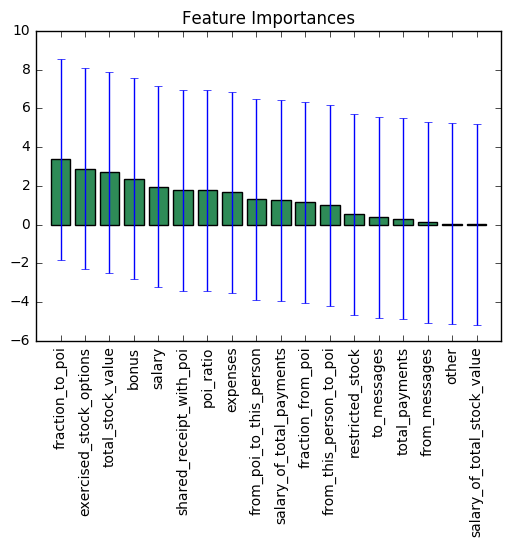

In [33]:
# Feature importances By SelectKBest

import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cross_validation import KFold
%matplotlib inline
import matplotlib.pyplot as plt

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(enron_df[predictors], enron_df["poi"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

indices = np.argsort(scores)[::-1]

sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])

# Plot the scores.  
plt.figure()
plt.title("Feature Importances")
plt.bar(range(np.size(predictors)), scores[indices],
       color="seagreen", yerr=np.std([indices]), align="center")
plt.xticks(range(np.size(predictors)), sorted_important_features, rotation='vertical')

plt.xlim([-1, np.size(predictors)])
plt.show()


Based on the above sorted importance value, drop columns of lower importance value. 
'salary_of_total_stock_value', 'other', 'from_messages', 'total_payments', 'to_messages'

In [34]:
# 13 features
predictors = ['bonus', 'exercised_stock_options', 'expenses','from_poi_to_this_person', 'from_this_person_to_poi',
 'restricted_stock', 'salary', 'shared_receipt_with_poi','total_stock_value', 'poi_ratio', 'fraction_to_poi',
 'fraction_from_poi', 'salary_of_total_payments']

# 8 features
predictors_8 = ['bonus', 'exercised_stock_options', 'total_stock_value', 'fraction_to_poi',  'expenses', 'salary',
              'shared_receipt_with_poi', 'poi_ratio' ]

# 4 features
predictors_4 = ['bonus', 'exercised_stock_options', 'total_stock_value', 'fraction_to_poi']



In [35]:
# Split the data at first on training and test data. We will use Stratified Shuffle Split due to small dataset
labels = enron_df['poi'].copy(deep=True).astype(int).as_matrix()

#features = enron_df['total_payments', 'total_stock_value', 'poi_ratio', 'fraction_to_poi', 'fraction_from_poi'].as_matrix()
#features = (enron_df.drop('poi', axis=1)).fillna(0).copy(deep=True).as_matrix()
features = (enron_df[predictors]).fillna(0).copy(deep=True).as_matrix()

print labels
print features


[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1]
[[  6.00000000e+05   0.00000000e+00   9.42990000e+04 ...,   3.44827586e+00
    4.70879802e+00   3.44489262e+01]
 [  1.20000000e+06   6.68054400e+06   1.12000000e+04 ...,   0.00000000e+00
    0.00000000e+00   4.74060596e+00]
 [  3.50000000e+05   4.89034400e+06   7.85520000e+04 ...,   0.00000000e+00
    0.00000000e+00   8.07372771e+01]
 ..., 
 [  6.00000000e+05   3.18125000e+06   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   2.42722596e+01]
 [  8.00000000e+05   7.65920000e+05   9.62680000e+04 ...,   5.00000000e+01
    2.17341040e+01   3.18124829e+01]
 [  6.00000000e+05   3.84728000e+05   1.25978000e+05 ...,   3.75000000e+01
    5.95647194e+00   2.16127060e+01]]


#### Properly scale features (related mini-project: Lesson 9)

If algorithm calls for scaled features, feature scaling is deployed.

In [36]:
# Scale feature 'salary'
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 100), copy=True)
salary_scaled = scaler.fit_transform(enron_df['salary'])


/Users/LiWang/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/LiWang/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


### Pick and Tune an Algorithm

#### Try out varity of classifiers (related mini-project: Lessons 1-3)

<p>
<div style="background-color:#d9d9d9">Try a varity of classifier.  Please name your classifier clf for easy export below.  Note that if you want to do PCA or other multi-stage operations, you'll need to use Pipelines. For more info:
http://scikit-learn.org/stable/modules/pipeline.html
<p><p>
At least 2 different algorithms are attempted and their performance is compared, with the more performant one used in the final analysis.</div>

In [37]:
# Try GaussianNB
from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()
scores = sklearn.cross_validation.cross_val_score(gnb_clf, enron_df[predictors_8], labels)
print scores
print 'GaussianNB mean score:', scores.mean()

# features, scores.mean()
# 13, 0.817080378251
# 4, 0.86628250591
# 8, 0.852245862884

# Try SVC
from sklearn.svm import SVC
svc_clf = SVC()
scores = sklearn.cross_validation.cross_val_score(svc_clf, enron_df[predictors_8], labels)
print scores
print 'SVC:', scores.mean()

# features, scores.mean()
# 13, 0.887411347518
# 4, 0.887411347518
# 8, 0.887411347518

# Try ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier
erf_clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
scores = sklearn.cross_validation.cross_val_score(erf_clf, enron_df[predictors_8], labels)
print scores
print 'ExtraTreesClassifier mean score:', scores.mean()

# features, scores.mean()
# 13, 0.880319148936
# 4, 0.873522458629
# 8, 0.859338061466

# Try RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=10)
scores = sklearn.cross_validation.cross_val_score(rf_clf, enron_df[predictors_8], labels)
print scores
print 'RAndomForestClassifier mean score:', scores.mean()

# features, scores.mean()
# 13, 0.86628250591
# 4, 0.880319148936
# 8, 0.873226950355

# Try AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
ab_clf = AdaBoostClassifier(n_estimators=100)
scores = sklearn.cross_validation.cross_val_score(ab_clf, enron_df[predictors_8], labels)
print scores 
print 'AdaBoostClassifier mean score:', scores.mean()

# features, scores.mean()
# 13, 0.845005910165
# 4, 0.831117021277
# 8, 0.837913711584

# Try Logistic Regression
from sklearn.linear_model import LogisticRegression
lreg_clf = LogisticRegression()
scores = sklearn.cross_validation.cross_val_score(lreg_clf, enron_df[predictors_8], labels)
print scores 
print 'LogisticRegression mean score:', scores.mean()

# features, scores.mean()
# 8,        0.754137115839

# Try LinearSVC
from sklearn.svm import LinearSVC
lsvc_clf = LinearSVC()
scores = sklearn.cross_validation.cross_val_score(lsvc_clf, enron_df[predictors_8], labels)
print scores 
print 'LinearSVC mean score:', scores.mean()

# features, scores.mean()
# 8,        0.621453900709

[ 0.83333333  0.91489362  0.80851064]
GaussianNB mean score: 0.852245862884
[ 0.875       0.89361702  0.89361702]
SVC: 0.887411347518
[ 0.83333333  0.85106383  0.89361702]
ExtraTreesClassifier mean score: 0.859338061466
[ 0.875       0.89361702  0.87234043]
RAndomForestClassifier mean score: 0.880319148936
[ 0.85416667  0.85106383  0.80851064]
AdaBoostClassifier mean score: 0.837913711584
[ 0.66666667  0.76595745  0.82978723]
LogisticRegression mean score: 0.754137115839
[ 0.8125      0.85106383  0.31914894]
LinearSVC mean score: 0.660904255319



Comparing Classifiers based on cross validation scores:

1st Tier: SVC, RandomForestClassifier 

2nd Tier: GaussianNB, ExtraTreesClassifier, AdaBoostClassifier

3st Tier: LogisticRegression, LinearSVC


#### Univariate feature selection with F-test for feature scoring 
<p>
<div style="background-color:#d9d9d9">using the default selection function: the 10% most significant features</div>

<Container object of 13 artists>

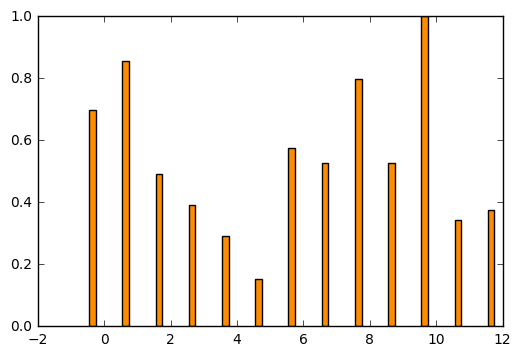

In [38]:
# Univariate feature selection with SelectPercentile
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile, f_classif

selector = SelectPercentile(f_classif, percentile=10)
selector.fit(features, labels)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

X_indices = np.arange(features.shape[-1])
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange')


In [ ]:
# use FeatureUnion to combine features obtained by PCA and univariate selection ?????

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

# This dataset is way too high-dimensional. Better do PCA:
pca = PCA(n_components=8)

# Maybe some original features where good, too?
selection = SelectKBest(k=4)

# Build estimator from PCA and Univariate selection:
combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(features, labels).transform(features)

svm = SVC(kernel="linear")

# Do grid search over k, n_components and C:
pipeline = Pipeline([("features", combined_features), ("svm", svm)])

param_grid = dict(features__pca__n_components=[1, 2, 3],
                  features__univ_select__k=[1, 2],
                  svm__C=[0.1, 1, 10])

grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=10)
grid_search.fit(features, labels)
print(grid_search.best_estimator_)

#print(grid_search.best_estimator_.steps)

#for step in grid_search.best_estimator_.steps:
#    print(type(step))
#    print(step.get_params())

In [ ]:
# Get the score of the above ?????
#scores = sklearn.cross_validation.cross_val_score(svm, X_features, labels)
#print 'Linear SVC after PCA mean score:', scores.mean()

The pipeline provides a handy tool called the FeatureUnion which allows the results of multiple feature selection and extraction procedures to be combined into a larger dataset on which a model can be trained. Importantly, all the feature extraction and the feature union occurs within each fold of the cross validation procedure.  The pipeline is then evaluated using 10-fold cross validation.

In [39]:
# Create a pipeline that extracts features from the data using PCA and SelectKBest then creates a model_SVC

from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

# create feature union
features_pipeline = []
features_pipeline.append(('pca', PCA(n_components=4)))
features_pipeline.append(('select_best', SelectKBest(k=8)))
feature_union = FeatureUnion(features_pipeline)

# create pipeline for rbfSVC
estimators = []
estimators.append(('feature_union', feature_union))
#estimators.append(('logistic', LogisticRegression()))
estimators.append(('svc', SVC(kernel='rbf', class_weight='balanced')))
model_svc = Pipeline(estimators)

#print sorted(model_svc.get_params().keys())
# ['feature_union', 'feature_union__n_jobs', 'feature_union__pca', 'feature_union__pca__copy', 
# 'feature_union__pca__iterated_power', 'feature_union__pca__n_components', 'feature_union__pca__random_state', 
# 'feature_union__pca__svd_solver', 'feature_union__pca__tol', 'feature_union__pca__whiten', 
# 'feature_union__select_best', 'feature_union__select_best__k', 'feature_union__select_best__score_func', 
# 'feature_union__transformer_list', 'feature_union__transformer_weights', 'steps', 
# 'svc', 'svc__C', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 
# 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 
# 'svc__shrinking', 'svc__tol', 'svc__verbose']

# find best fitting parameter
param_grid = {
            'svc__C': [1e3, 5e3, 1e4, 5e4, 1e5],
            'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1 ],
            'svc__degree': [1, 2, 3, 4, 5]
}

grid_svc = GridSearchCV(model_svc, param_grid)
grid_svc = grid_svc.fit(features, labels)
print grid_svc.best_estimator_

# best fitting svc_clf
best_svc_pipe = grid_svc.best_estimator_ 

# evaluate pipeline for rbfSVC
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
scores_svc = cross_val_score(model_svc, enron_df[predictors], labels, cv=kfold)
print 'rbfSVC mean score:', scores_svc.mean()

# rbfSVC mean score:
# 0.886666666667




/Users/LiWang/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Pipeline(steps=[('feature_union', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('select_best', SelectKBest(k=8, score_func=<function f_classif at 0x117ccbb90>))],
       transform...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
rbfSVC mean score: 0.886666666667


In [41]:
# create pipeline for RandomForest

from sklearn.ensemble import RandomForestClassifier

estimators = []
estimators.append(('feature_union', feature_union))
#estimators.append(('logistic', LogisticRegression()))
estimators.append(('RandomForest', RandomForestClassifier()))
model_rf = Pipeline(estimators)

#print sorted(model_rf.get_params().keys())
#['RandomForest', 'RandomForest__bootstrap', 'RandomForest__class_weight', 'RandomForest__criterion', 
#'RandomForest__max_depth', 'RandomForest__max_features', 'RandomForest__max_leaf_nodes', 
#'RandomForest__min_impurity_split', 'RandomForest__min_samples_leaf', 'RandomForest__min_samples_split', 
#'RandomForest__min_weight_fraction_leaf', 'RandomForest__n_estimators', 'RandomForest__n_jobs', 
#'RandomForest__oob_score', 'RandomForest__random_state', 'RandomForest__verbose', 'RandomForest__warm_start', 
#'feature_union', 'feature_union__n_jobs', 'feature_union__pca', 'feature_union__pca__copy', 
#'feature_union__pca__iterated_power', 'feature_union__pca__n_components', 'feature_union__pca__random_state', 
#'feature_union__pca__svd_solver', 'feature_union__pca__tol', 'feature_union__pca__whiten', 
#'feature_union__select_best', 'feature_union__select_best__k', 'feature_union__select_best__score_func', 
#'feature_union__transformer_list', 'feature_union__transformer_weights', 'steps']


# find best fitting parameter
param_grid = {'RandomForest__n_estimators': [10,20,30,40,50],
               'RandomForest__min_samples_split' :[2,3,4,5],
               'RandomForest__min_samples_leaf' : [1,2,3]
             }

grid_rf = GridSearchCV(model_rf, param_grid)
grid_rf = grid_rf.fit(features, labels)
print grid_rf.best_estimator_

# best fitting svc_clf
best_rf_pipe = grid_rf.best_estimator_ 


# evaluate pipeline for rf
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
scores_rf = cross_val_score(model_rf, enron_df[predictors], labels, cv=kfold)
print 'RandomForest mean score:', scores_rf.mean()

# RandomForest mean score:
# 0.872380952381

Pipeline(steps=[('feature_union', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('select_best', SelectKBest(k=8, score_func=<function f_classif at 0x117ccbb90>))],
       transform...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
RandomForest mean score: 0.872380952381


#### Discuss parameter tuning and its importance.

<p>
<div style="background-color:#d9d9d9">Response addresses what it means to perform parameter tuning and why it is important.</div>

Algorithms may perform differently using different parameters depending on the structure of your data. If you don’t do this well, you can over-tune an algorithm to predict your training data extremely well, 
but fail miserably on unseen data.

#### Tune the algorithm (related mini-project: Lessons 2, 3, 13)

<p>
<div style="background-color:#d9d9d9">At least one important parameter tuned with at least 3 settings investigated systematically, or any of the following are true:
<p><p>
GridSearchCV used for parameter tuning,<p>
Several parameters tuned,<p>
Parameter tuning incorporated into algorithm selection (i.e. parameters tuned for more than one algorithm, and best algorithm-tune combination selected for final analysis).</div>

In [42]:
# Find best fit param for rbf SVM with PCA and cross validation

from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV

# Compute a PCA
n_comp = 4
pca = PCA(n_components=n_comp).fit(features)
features_pca = pca.transform(features)
#print 'features_pca:', features_pca

# Train a SVM classification model
param_grid = {
            'C': [1e3, 5e3, 1e4, 5e4, 1e5],
            'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1 ],
            'degree': [1, 2, 3, 4, 5]
}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(features_pca, labels)
print clf.best_estimator_

best_svc_clf = clf.best_estimator_ 

scores = sklearn.cross_validation.cross_val_score(best_svc_clf, features, labels)
print 'SVC after PCA mean score:', scores.mean()

# n_comp, Mean score
# 8, 0.887411347518
# 4, 0.887411347518

SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=1, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
SVC after PCA mean score: 0.887411347518


In [45]:
# get the best fitting parameters  RandomForest
#from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV

# Compute a PCA
#n_comp = 8
#pca = PCA(n_components=n_comp).fit(features)
#features_pca = pca.transform(features)

#cv = KFold(n_splits=5)

parameters = {'n_estimators': [10,20,30,40,50],
               'min_samples_split' :[2,3,4,5],
               'min_samples_leaf' : [1,2,3]
             }

rf_clf = RandomForestClassifier()
grid_obj = GridSearchCV(rf_clf, parameters)
grid_fit = grid_obj.fit(features_pca, labels)

best_rf_clf = grid_fit.best_estimator_ 

best_rf_clf.fit(features,labels)

scores = sklearn.cross_validation.cross_val_score(clf, features, labels)
print 'RandomForest mean score:', scores.mean()

# Mean score
# 0.887411347518

RandomForest mean score: 0.887411347518


### Validate and Evaluate

#### Discuss validation and its importance.

<p>
<div style="background-color:#d9d9d9">Response addresses what validation is and why it is important.</div>

Validation is the processed of checking to see how your model performs on unseen data. A classic mistake would 
be tuning your model be able to predict your training data very well , but then having it perform poorly on unseen 
out-of-sample testing data. This is called overfitting. One of the major goals in validation is to avoid overfitting, 
which can be accomplished through a process called cross-validation.

#### Usage of Evaluation Metrics (related mini-project: Lesson 14)
<p>
<div style="background-color:#d9d9d9">At least two appropriate metrics are used to evaluate algorithm performance (e.g. precision and recall), and the student articulates what those metrics measure in context of the project task.</div>

Precision can be thought of as the ratio of how often your model is actually correct in identifying a positive label to the total times it guesses a positive label. A higher precision score would mean less false positives.

Recall can be thought of as the ratio of how often your model correctly identifies a label as positive to how many total positive labels there actually are. A higher recall score would mean less false negatives.

#### Validation Strategy (related mini-project: Lesson 13)
<p>
<div style="background-color:#d9d9d9">Performance of the final algorithm selected is assessed by splitting the data into training and testing sets or through the use of cross validation, noting the specific type of validation performed. Tune your classifier to achieve better than .3 precision and recall using our testing script. 
<p><p>
Check the tester.py script in the final project folder for details on the evaluation method, especially the test_classifier function. Because of the small size of the dataset, the script uses stratified shuffle split cross validation.</div> 

In [ ]:
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

In [86]:
# prepare parameters for dump_classifier 

from collections import OrderedDict

# available choice for clf_dump: best_svc_grid, best_svc_clf, best_rf_grid, best_rf_clf
clf_dump = best_svc_clf

#features_list = list(df_imp_sub.columns.values)
features_list = predictors

#data = enron_df[features_list].fillna(0).to_dict(orient='records')
data = enron_df.to_dict(orient='records')

my_dataset = {}

counter = 0
for item in data:
    my_dataset[counter] = item
    counter += 1

print my_dataset[0]  

{'salary': 365788.0, 'to_messages': 807.0, 'salary_of_total_payments': 34.44892623751327, 'total_payments': 1061827.0, 'fraction_from_poi': 4.708798017348203, 'bonus': 600000.0, 'poi_ratio': 4.6650717703349285, 'total_stock_value': 585062.0, 'expenses': 94299.0, 'fraction_to_poi': 3.4482758620689653, 'exercised_stock_options': 0.0, 'from_messages': 29.0, 'other': 1740.0, 'from_this_person_to_poi': 1.0, 'poi': False, 'salary_of_total_stock_value': 62.5212370654734, 'shared_receipt_with_poi': 702.0, 'restricted_stock': 585062.0, 'from_poi_to_this_person': 38.0}


In [96]:
#data_list = enron_df[predictors].to_dict()
data_list = enron_df.to_dict(orient='records')
#print data

data_dict = {}
counter = 0
for item in data_list:
    data_dict[counter] = item

#print 'data_list[0]:', data_list[0]
    
poi_list = enron_df['poi'].to_dict()
poi_dict = {}
counter = 0
for item in poi_list:
    poi_dict[counter] = item

#print data_list

my_dataset = dict(poi_dict.items() + data_dict.items())

#print my_dataset[0]

In [97]:
enron_df.head(2)

,poi,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,salary_of_total_payments,salary_of_total_stock_value,poi_ratio,fraction_to_poi,fraction_from_poi
0,False,600000.0,0.0,94299.0,29.0,38.0,1.0,1740.0,585062.0,365788.0,702.0,807.0,1061827.0,585062.0,34.448926,62.521237,4.665072,3.448276,4.708798
1,False,1200000.0,6680544.0,11200.0,0.0,0.0,0.0,2660303.0,3942714.0,267102.0,0.0,0.0,5634343.0,10623258.0,4.740606,2.514313,0.000000,0.000000,0.000000


In [64]:
test_classifier(clf, my_dataset, features_list)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of labels for any class cannot be less than 2.

In [ ]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!

from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)



### Dump your classifier, dataset, and features_list for checking

<p>
<div style="background-color:#d9d9d9">Dump your classifier, dataset, and features_list so anyone cancheck your results. You do not need to change anything below, but make sure that the version of poi_id.py that you submit can be run on its own and generates the necessary .pkl files for validating your results.</div>


In [ ]:
# 
dump_classifier_and_data(clf_dump, my_dataset, features_list)

### List of Resources


<p>
<div style="background-color:#d9d9d9">sklearn documentation: http://scikit-learn.org/stable/index.html
pandas documentation: http://pandas.pydata.org
Jason Brownlee on Machine Learning Process: http://machinelearningmastery.com</div>
